# Analysis & Results: Replicating the Findings

**Project:** Unsupervised Motor Signatures in ASD

**Paper Reference:** *Unsupervised Deep Learning Framework for Quantifying Atypical Motor Signatures in ASD*

## Overview
This notebook replicates the statistical analysis and visualizations presented in the results section of the manuscript.

## ⚠️ Privacy & Reproducibility Note
To protect participant privacy, the raw video and skeletal data cannot be shared.
* **Code Verification:** By default, this notebook runs on **simulated dummy data** to demonstrate that the analysis pipeline functions correctly.
* **Result Replication:** To reproduce the *exact* figures from the paper, we provide an `anonymized_results.csv` file containing the computed reconstruction errors and clinical scores for the study cohort. We also provide the exact model weights in `best_autoencoder_model.pth`.

In [1]:
import os
import torch

# 1. Force install PyTorch 2.8.0 with CUDA 12.6
# We use --upgrade --force-reinstall to overwrite whatever Colab loaded by default
!pip install torch==2.8.0+cu126 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 --upgrade

# 2. Verify the version before proceeding
import torch
print(f"Successfully installed PyTorch version: {torch.__version__}")

# 3. Set environment variable for PyG (PyTorch Geometric) installation
# This tells pip explicitly which binary wheels to grab
os.environ['TORCH'] = "2.8.0+cu126"

Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.24.1%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.9.1%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.24.0%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.9.0%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)


In [2]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric-temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 122.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 136.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 115.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 4.2 MB/s eta 0:00:00


## 1. Data Simulation and Model Definition
We repurpose the exact same code found in `2_ModelTraining.ipynb`

In [3]:
import torch
from torch.utils.data import Dataset
import numpy as np
from itertools import permutations

print("--- Simulating Datasets (Random Tensors) ---")

# Hyperparameters
NODES = 24          # 24 Skeletal Joints
FEATURES = 3        # x, y, z coordinates
TIMESTEPS = 60      # 60 frames (2 seconds)

class DummySTGCN_Dataset(Dataset):
    """
    Simulates the STGCN_Dataset class behavior using random noise.
    Returns (x, y, video_id) matching the real pipeline signature.
    Now includes get_edge_index() support.
    """
    def __init__(self, num_samples, is_control=True):
        self.num_samples = num_samples

        # 1. Create random features: [Num_Samples, Time, Nodes, Features] -> [N, 60, 24, 3]
        self.data = torch.randn(num_samples, TIMESTEPS, NODES, FEATURES)

        # 2. Create dummy labels: 0 for Control, 1 for ASD
        self.labels = torch.zeros(num_samples, dtype=torch.long) if is_control else torch.ones(num_samples, dtype=torch.long)

        # 3. Create dummy video IDs
        prefix = "Control" if is_control else "ASD"
        self.video_ids = [f"{prefix}_{1000+i}" for i in range(num_samples)]

        # 4. Generate Edge Index (Fully Connected Graph)
        # This matches the logic from your 'transform_to_graphs' function
        perm = torch.tensor(list(permutations(range(NODES), 2)), dtype=torch.long)
        self.edge_index = perm.t().contiguous()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Returns tuple: (X, y, video_id)
        return self.data[idx], self.labels[idx], self.video_ids[idx]

    def get_edge_index(self):
        """Helper function to get the constant edge_index."""
        return self.edge_index


# 1. Instantiate Dummy Datasets
# Simulating 100 training samples, 20 validation, 20 test
control_dataset_train = DummySTGCN_Dataset(num_samples=100, is_control=True)
control_dataset_val = DummySTGCN_Dataset(num_samples=20, is_control=True)
autism_dataset_test = DummySTGCN_Dataset(num_samples=20, is_control=False)

# 2. Verification (Your requested snippet)
if 'control_dataset_train' in locals() and len(control_dataset_train) > 0:
    sample_x, sample_y, video_id = control_dataset_train[0]

    print(f"Video ID: {video_id}")
    print(f"Window Shape: {sample_x.shape}")
    # Expected: [60, 24, 3] (Time, Nodes, Features)
    # Note: The Dataloader will add the Batch dimension later.

--- Simulating Datasets (Random Tensors) ---
Video ID: Control_1000
Window Shape: torch.Size([60, 24, 3])


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.attention import STConv

# --- Helper Decoder Block ---
class _DecoderBlock(nn.Module):
    """
    A decoder block that first upsamples the time dimension and then applies
    an STConv layer. This acts as a "Transposed STConv".
    """
    def __init__(self, in_channels, out_channels, hidden_channels, num_nodes, kernel_size, K):
        super(_DecoderBlock, self).__init__()
        # The STConv layer will reduce the time dim by (kernel_size - 1).
        # We need to calculate how much to upsample to counteract this and add 2 steps.
        # Net effect is an increase of 2 time steps, reversing the encoder's effect.
        self.temporal_padding = kernel_size + 5
        self.st_conv = STConv(num_nodes, in_channels, hidden_channels, out_channels, kernel_size, K)

    def forward(self, x, edge_index):
        # x shape: [Batch, Time, Nodes, Features]
        # Interpolate expects shape [B, C, H, W] or similar, so we permute.
        # We treat Time as Width and Nodes as Height.
        x_permuted = x.permute(0, 3, 2, 1) # [B, Features, Nodes, Time]

        # Calculate the target time dimension for upsampling
        target_time_dim = x.size(1) + self.temporal_padding

        # Upsample the time dimension using bilinear interpolation
        x_upsampled = F.interpolate(x_permuted, size=(x.size(2), target_time_dim), mode='bilinear', align_corners=False)

        # Permute back to the shape STConv expects
        x_permuted_back = x_upsampled.permute(0, 3, 2, 1) # [B, Time, Nodes, Features]

        # Apply the STConv layer
        output = self.st_conv(x_permuted_back, edge_index)
        return output

class STGCN_Autoencoder(nn.Module):
    def __init__(self, num_nodes, conv_depth, in_channels, hidden_channels, out_channels):
        """
        Initializes the Spatio-Temporal Graph Autoencoder.
        Args:
            num_nodes (int): The number of nodes in the graph (e.g., 24 landmarks).
            conv_depth (int): The number of STConv blocks in the encoder/decoder.
            in_channels (int): The number of features per node (e.g., 2 for x,y coords).
            hidden_channels (int): The number of hidden channels in the STConv blocks.
            out_channels (int): The number of features in the final embedding (latent space).
        """
        super(STGCN_Autoencoder, self).__init__()

        # --- Store key dimensions for reshaping ---
        self.num_nodes = num_nodes
        self.out_channels = out_channels
        kernel_size = 3
        K = 1

        # =====================================================================
        #                             1. ENCODER
        # Compresses the spatio-temporal data.
        # =====================================================================
        self.encoder_blocks = nn.ModuleList()
        # First block maps input features to output features
        self.encoder_blocks.append(
            STConv(num_nodes, in_channels, hidden_channels, out_channels, kernel_size, K)
        )
        # Subsequent blocks have the same number of features
        for _ in range(conv_depth - 1):
            self.encoder_blocks.append(
                STConv(num_nodes, out_channels, hidden_channels, out_channels, kernel_size, K)
            )

        # =====================================================================
        #                             2. DECODER
        # This is the symmetrical mirror image of the encoder, using our new
        # upsampling decoder blocks to reconstruct the original data.
        # =====================================================================
        self.decoder_blocks = nn.ModuleList()
        # First decoder blocks operate on the compressed feature dimension
        for _ in range(conv_depth - 1):
            self.decoder_blocks.append(
                _DecoderBlock(out_channels, out_channels, hidden_channels, num_nodes, kernel_size, K)
            )
        # The final block maps back to the original input feature dimension
        self.decoder_blocks.append(
            _DecoderBlock(out_channels, in_channels, hidden_channels, num_nodes, kernel_size, K)
        )

    def forward(self, x, edge_index):
        # --- ENCODING ---
        # Pass through STConv blocks, progressively reducing the time dimension.
        h = x
        for block in self.encoder_blocks:
            h = block(h, edge_index)
            # print(f"Encoder block output shape: {h.shape}")
        # `h` is now the compressed spatio-temporal representation (the bottleneck).
        # print(f"Encoder output shape: {h.shape}")

        # --- Latent Vector Generation (Optional) ---
        # We can still create a single latent vector for other tasks if needed,
        # but the decoder will work directly on the feature map `h`.
        latent_vector = torch.mean(h, dim=(1, 2))

        # --- DECODING ---
        # Pass through the upsampling decoder blocks, progressively
        # increasing the time dimension back to the original size.
        reconstructed = h
        for block in self.decoder_blocks:
            reconstructed = block(reconstructed, edge_index)
            # print(f"Decoder block output shape: {reconstructed.shape}")
        # `reconstructed` is now the reconstructed spatio-temporal data.
        # print(f"Decoder output shape: {reconstructed.shape}")

        # The final `reconstructed` shape now matches the input `x` shape.
        return reconstructed, latent_vector

## 2. Model Evaluation on ASD Cohort
We apply the trained normative model to the **ASD Test Set**. Since the Autoencoder learned to reconstruct only "neurotypical" movement patterns, we hypothesize that the ASD samples will exhibit significantly higher reconstruction errors (MSE).

**Statistical Validation:**
We perform an independent **two-sample t-test** ($p < 0.05$) to quantify the difference between the reconstruction error distributions of the Control Validation set and the ASD Test set.

In [5]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from torch.utils.data import DataLoader

control_val_loader = DataLoader(control_dataset_val, batch_size=16, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

# --- 1. Load the Trained Model ---
# Define the model architecture EXACTLY as it was during training
model = STGCN_Autoencoder(
    num_nodes=24,
    conv_depth=2,
    in_channels=3,
    hidden_channels=8,
    out_channels=32,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

best_model_path = 'best_autoencoder_model.pth'
try:
    model.load_state_dict(torch.load(best_model_path, map_location=device))
except FileNotFoundError:
    print(f"Error: Model file not found at '{best_model_path}'.")
    exit()

model.to(device)
model.eval()

# --- 2. Calculate Reconstruction Errors on the Validation Set ---
val_reconstruction_errors = []
criterion = nn.MSELoss(reduction='none')

try:
    edge_index = control_dataset_val.get_edge_index().to(device)
except NameError:
    print("Error: `control_dataset_val` is not defined.")
    exit()

print("\n--- Calculating reconstruction errors on validation set... ---")
progress_bar = tqdm(control_val_loader, desc="Validating")

with torch.no_grad():
    for batch_X, _, _ in progress_bar:
        batch_X = batch_X.to(device)
        reconstructed_X, _ = model(batch_X, edge_index)
        loss = criterion(reconstructed_X, batch_X)
        per_window_error = torch.mean(loss, dim=(1, 2, 3))
        val_reconstruction_errors.extend(per_window_error.cpu().numpy())

print("Calculation complete.")

# --- 3. Calculate the Anomaly Threshold using the IQR Method ---
val_errors_array = np.array(val_reconstruction_errors)

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
q1 = np.percentile(val_errors_array, 25)
q3 = np.percentile(val_errors_array, 75)
iqr = q3 - q1

# Define the outlier threshold using the 1.5*IQR rule
anomaly_threshold = q3 + 1.5 * iqr

print("\n--- Calculating Thresholds ---")
print(f"Q1 (25th percentile): {q1:.6f}")
print(f"Q3 (75th percentile): {q3:.6f}")
print(f"IQR (Interquartile Range): {iqr:.6f}")
print(f"Anomaly Threshold (Q3 + 1.5*IQR): {anomaly_threshold:.6f}")

# --- 4. Test Set ---
autism_test_loader = DataLoader(autism_dataset_test, batch_size=16, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)
val_reconstruction_errors = []
criterion = nn.MSELoss(reduction='none') # Get per-element loss, not the mean

# Get the edge_index once from the dataset
# Make sure `control_dataset_val` is defined and is your validation dataset instance
try:
    edge_index = control_dataset_val.get_edge_index().to(device)
except NameError:
    print("Error: `control_dataset_val` is not defined.")
    print("Please ensure your validation dataset object is created and named correctly.")
    exit()

print("\n--- Calculating reconstruction errors on validation set... ---")
progress_bar = tqdm(autism_test_loader, desc="Validating")

with torch.no_grad():
    for batch_X, _, _ in progress_bar:
        batch_X = batch_X.to(device)

        # Get the model's reconstruction
        reconstructed_X, _ = model(batch_X, edge_index)

        # Calculate the loss for each item in the batch individually
        # This gives us a loss value per window, not per batch
        loss = criterion(reconstructed_X, batch_X)
        # We average the error across all nodes, features, and time steps for each window
        per_window_error = torch.mean(loss, dim=(1, 2, 3))

        # Extend the list with the errors from this batch
        val_reconstruction_errors.extend(per_window_error.cpu().numpy())

print("Calculation complete.")

# Convert the list to a NumPy array for easier calculations
test_errors_array = np.array(val_reconstruction_errors)

# --- 5. Do an unpaired t-test to check the distribution difference ---
t_statistic, p_value = stats.ttest_ind(val_errors_array, test_errors_array)

Using device: cuda

--- Calculating reconstruction errors on validation set... ---


Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Calculation complete.

--- Calculating Thresholds ---
Q1 (25th percentile): 1.196557
Q3 (75th percentile): 1.239753
IQR (Interquartile Range): 0.043196
Anomaly Threshold (Q3 + 1.5*IQR): 1.304546

--- Calculating reconstruction errors on validation set... ---


Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Calculation complete.


## 3. Visualization: Reconstruction Error Distributions
We visualize the separation between the two groups using density histograms.

**Key Visual Elements:**
* **Blue/Orange Distributions:** Compare the error density of Control vs. ASD samples. A larger overlap indicates lower separability.
* **Red Dashed Line (Anomaly Threshold):** Represents the $Q3 + 1.5 \times IQR$ cutoff derived from the Control group. Samples to the right of this line are statistically flagged as "atypical."
* **Statistical Annotations:** The $t$-statistic and $p$-value are embedded directly in the plot for immediate significance checking.

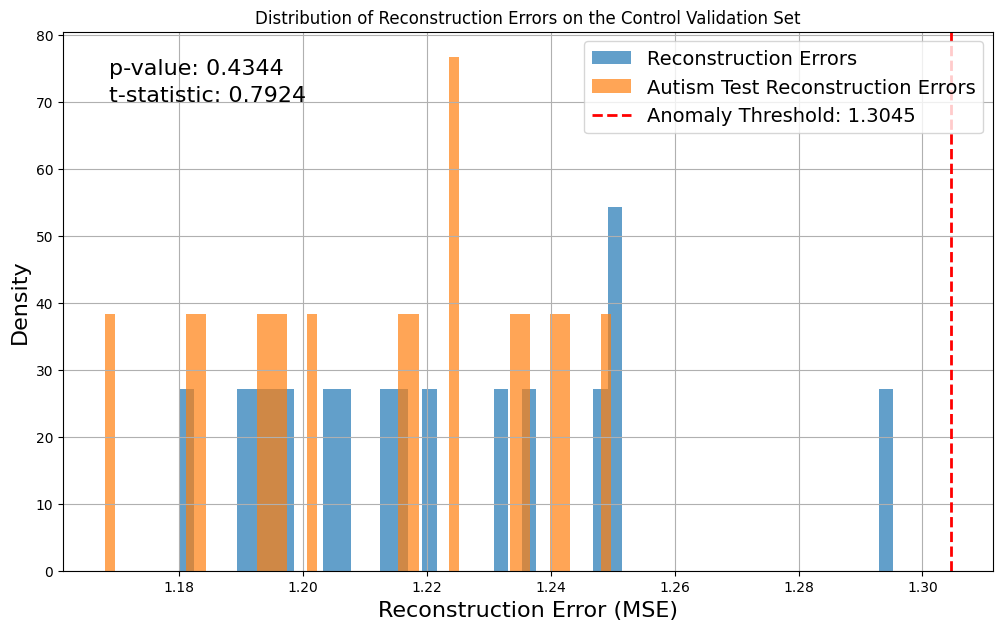

In [6]:
# --- 6. Plot the distributions with anomaly threshold lines and p_value and t_stats as legends
plt.figure(figsize=(12, 7))
plt.hist(val_errors_array, bins=50, alpha=0.7, label='Reconstruction Errors', density=True)
plt.hist(test_errors_array, bins=50, alpha=0.7, label='Autism Test Reconstruction Errors', density=True)

# Add vertical lines for threshold
plt.axvline(anomaly_threshold, color='r', linestyle='--', linewidth=2, label=f'Anomaly Threshold: {anomaly_threshold:.4f}')

# Add p-value and t-stats as a label
plt.text(0.05, 0.95, f'p-value: {p_value:.4f}', transform=plt.gca().transAxes, verticalalignment='top', fontsize=16)
plt.text(0.05, 0.90, f't-statistic: {t_statistic:.4f}', transform=plt.gca().transAxes, verticalalignment='top', fontsize=16)

plt.title('Distribution of Reconstruction Errors on the Control Validation Set')
plt.xlabel('Reconstruction Error (MSE)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

## 4. Replication with Anonymized Manuscript Data
To ensure the reproducibility of the paper's findings without compromising participant privacy, we provide **pre-computed anonymized results** from the manuscript.

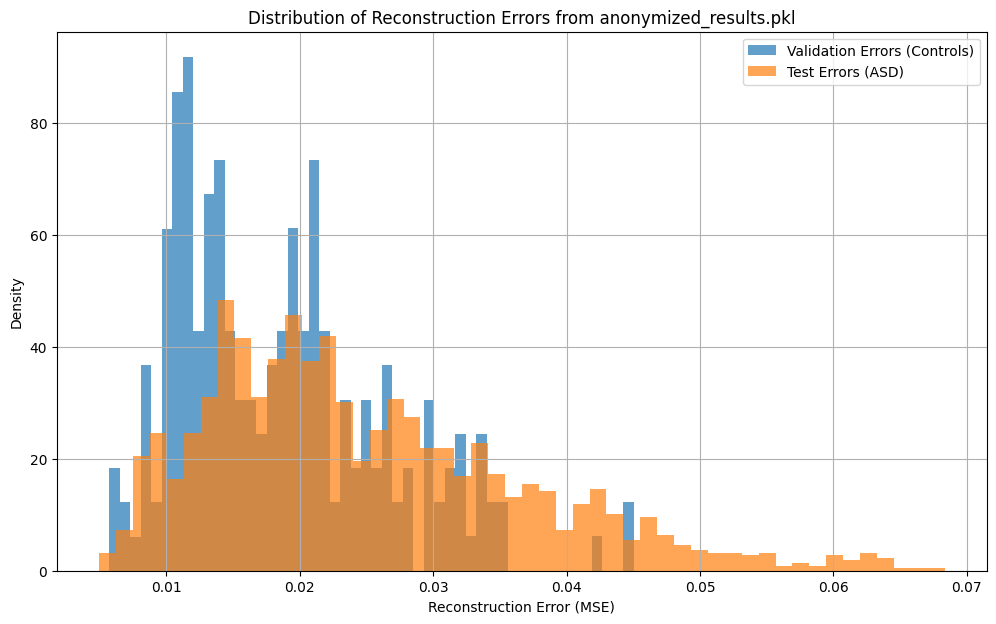

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the anonymized_results.pkl file
try:
    with open('anonymized_results.pkl', 'rb') as f:
        data = pd.read_pickle(f)
except FileNotFoundError:
    print("Error: 'anonymized_results.pkl' not found. Please ensure it's available in the environment.")
    exit()

# 2. Extract val_errors and test_errors
val_errors = data['val_errors']
test_errors = data['test_errors']

# 3. Plot the distributions as overlapping histograms
plt.figure(figsize=(12, 7))
plt.hist(val_errors, bins=50, alpha=0.7, label='Validation Errors (Controls)', density=True)
plt.hist(test_errors, bins=50, alpha=0.7, label='Test Errors (ASD)', density=True)

plt.title('Distribution of Reconstruction Errors from anonymized_results.pkl')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()